In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os
import pathlib

In [2]:
ini_wd = os.getcwd()
os.chdir('..')

from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters, pack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
from clusterization.all_methods import cluster_data_1d, cluster_data
from local_models import calc_cond_var_fuzzy, calculate_retraining_garch_forecasts
from antecedent_fitting import fit_antecedent_params
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
INPUT = pathlib.Path(config['files_folders']['processed'])
LOGS = pathlib.Path(config['files_folders']['logs'])

In [5]:
logging.basicConfig(level=logging.DEBUG,
                    filename=LOGS/'ets_testing.log',
                    filemode='w',
                    format='%(asctime)s.%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

In [6]:
pd.options.display.max_colwidth = 500

# Reading files

In [7]:
rtsi = pd.read_pickle(INPUT/'rtsi.pkl')

In [8]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
1995-09-04,99.80,99.80,99.80,99.80,1000395,-0.002000,-0.002002
1995-09-05,100.42,100.42,100.42,100.42,1669902,0.006212,0.006193
1995-09-06,99.74,99.74,99.74,99.74,927829,-0.006772,-0.006795
1995-09-07,101.30,101.30,101.30,101.30,2153945,0.015641,0.015520
1995-09-08,101.30,101.30,101.30,101.30,1318431,0.000000,0.000000
...,...,...,...,...,...,...,...
2022-09-28,1055.17,1082.49,1050.69,1074.57,860170151,0.020039,0.019841
2022-09-29,1089.57,1092.62,1054.68,1072.26,746668464,-0.002150,-0.002152
2022-09-30,1094.77,1172.16,1037.78,1055.72,1940913502,-0.015425,-0.015546


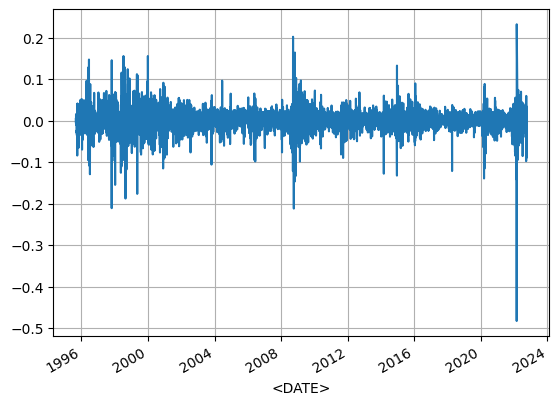

In [9]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [10]:
rtsi['log return'].describe()

count    6771.000000
mean        0.000354
std         0.025407
min        -0.482921
25%        -0.010185
50%         0.001224
75%         0.011688
max         0.232044
Name: log return, dtype: float64

In [11]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [12]:
rtsi['day of week']

<DATE>
1995-09-04    1
1995-09-05    2
1995-09-06    3
1995-09-07    4
1995-09-08    5
             ..
2022-09-28    3
2022-09-29    4
2022-09-30    5
2022-10-03    1
2022-10-04    2
Name: day of week, Length: 6771, dtype: int64

# Setting data & parameters

In [13]:
rescale_factor = 1
start_date = '2018-01-01'
end_date = '2020-07-01'

In [14]:
input_data = rtsi['log return'].loc[start_date:end_date].copy() * rescale_factor

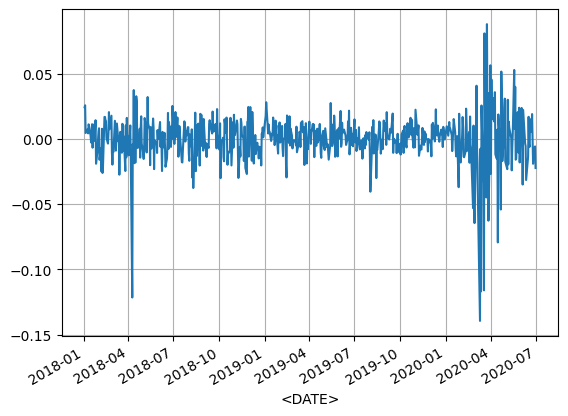

In [15]:
input_data.plot()

plt.grid()
plt.show()

In [16]:
input_data.describe()

count    627.000000
mean       0.000078
std        0.018531
min       -0.139486
25%       -0.007400
50%        0.001318
75%        0.009427
max        0.088251
Name: log return, dtype: float64

In [17]:
n = input_data.shape[0]
n

627

## Train / test split

In [18]:
n_train = 1  # 2000

# n_test = 100
# n_test = min(n - n_train, n_test)

In [19]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

n_test = test.shape[0]

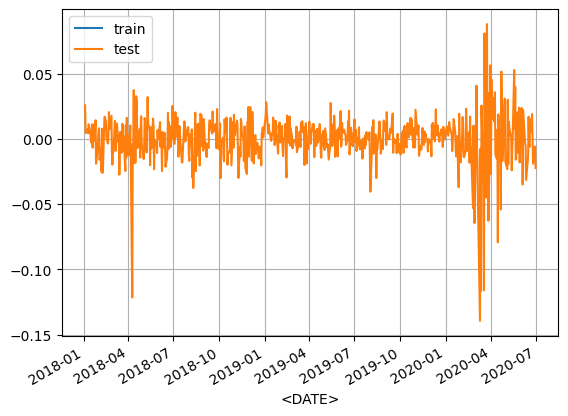

In [20]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [21]:
train.describe()

count    1.000000
mean     0.024498
std           NaN
min      0.024498
25%      0.024498
50%      0.024498
75%      0.024498
max      0.024498
Name: log return, dtype: float64

In [22]:
test.describe()

count    626.000000
mean       0.000039
std        0.018520
min       -0.139486
25%       -0.007418
50%        0.001316
75%        0.009403
max        0.088251
Name: log return, dtype: float64

## Antecedent parameters

In [23]:
clusterization_method = 'eTS'
membership_function = 'gaussian'

In [24]:
variance = 2
n_clusters = 1
sigma = 0
potentials_focal = np.array([1] * n_clusters)
delta_min = variance / 8

clusterization_parameters = {
    'n_clusters': n_clusters,
#     'centers': centers,
    'variance': variance,
    'sigma': sigma,
#     'beta': beta,
    'potentials_focal': potentials_focal,
    'delta_min': delta_min
}

In [25]:
n_last_points_to_use_for_clustering = None
normalize = True

## Consequent parameters

In [26]:
## technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'
n_points_fitting = None

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

# train_sample_std = train.std()
# first_h = [train_sample_std ** 2] * starting_index
past_h_type = 'rule-wise'
first_h = [train[0] ** 2] * starting_index
first_h = np.array([first_h for _ in range(n_clusters)]).T.copy()

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+1000] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

## $p$, $q$ - dependent antecedent parameters

## $h_t = \alpha_0 + \sum_{i = 1}^{q} \alpha_i y_{t - i}^2 + \sum_{j = 1}^{p} \beta_j h_{t - j}$

## $p = 1$, $q = 1$

## $x_t = (y_{t - 1}, h_{t - 1})$

In [27]:
x_dim = q  # p + q + 1 is also possible (if output value y_t is also used for clustering)

# data_to_cluster = pd.DataFrame([[train.values[0], first_h[0]]], index=train.index).copy()
data_to_cluster = train.iloc[:1].to_frame()

centers = np.array([data_to_cluster.iloc[0].values]).copy()
beta = np.array([0] * x_dim)

clusterization_parameters.update({
    'x_dim': x_dim,
    'centers': centers,
    'beta': beta
})

### Using classic GARCH to get initial parameters values

In [28]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -2.136815741255927
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.2902421409759484
            Iterations: 1
            Function evaluations: 15
            Gradient evaluations: 1


In [29]:
garch_fitted.params

omega       0.0003
alpha[1]    0.0100
beta[1]     0.4900
Name: params, dtype: float64

In [30]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [31]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [32]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [33]:
parameters_ini

{'alpha_0': array([0.00030007]),
 'alpha': array([[0.01]]),
 'beta': array([[0.49]])}

In [34]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

### Setting dict w/ all consequent parameters

In [35]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [36]:
# cluster_sets_conjunction = 'prod'

optimization = 'ls'
optimization_parameters = {'ftol': 1e-10,
                           'gtol': 1e-10,
                           'method': 'trf',
                           'verbose': 0
                          }

# Testing `FuzzyVolatilityModel` class

In [37]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           membership_function=membership_function,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           normalize=normalize,
                           n_points_fitting=n_points_fitting,
                           first_h=first_h,
                           optimization=optimization,
                           optimization_parameters=optimization_parameters,
                           clustered_space_dim=x_dim,
                           past_h_type=past_h_type
                          )

In [38]:
fvm.n_clusters = 1
fvm.membership_degrees_current = np.array([1])

## `cluster()`

In [39]:
%%time

# fvm.cluster()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 12.2 µs


In [40]:
fvm.data_to_cluster

,log return
<DATE>,
2018-01-03,0.024498


In [41]:
fvm._n_clusters_hist

[]

## `fit()`

In [42]:
fvm._fitting_slice

slice(None, None, None)

In [43]:
%%time

fvm.fit()

CPU times: user 18.7 ms, sys: 2.86 ms, total: 21.5 ms
Wall time: 23.5 ms


In [44]:
fvm.first_h_current

array([[0.00060013]])

In [45]:
fvm.bounds

([0, 0, 0], [1000, 1, 1])

In [46]:
np.array(fvm.bounds).T

array([[   0, 1000],
       [   0,    1],
       [   0,    1]])

In [47]:
fvm.alpha_0

array([0.00030007])

In [48]:
fvm.alpha

array([[0.01]])

In [49]:
fvm.beta

array([[0.49]])

In [50]:
garch_fitted.params

omega       0.0003
alpha[1]    0.0100
beta[1]     0.4900
Name: params, dtype: float64

In [51]:
fvm._parameters_hist

[{'alpha_0': array([0.00030007]),
  'alpha': array([[0.01]]),
  'beta': array([[0.49]])}]

In [52]:
fvm.membership_degrees_current

array([1])

In [53]:
fvm.clusters_parameters_current

{'n_clusters': 1,
 'variance': 2,
 'sigma': 0,
 'potentials_focal': array([1]),
 'delta_min': 0.25,
 'x_dim': 1,
 'centers': array([[0.02449759]]),
 'beta': array([0])}

In [54]:
data_to_cluster

,log return
<DATE>,
2018-01-03,0.024498


In [55]:
fvm._membership_degrees_hist

[]

In [56]:
fvm.train_data

<DATE>
2018-01-03    0.024498
Name: log return, dtype: float64

## `forecast()`

In [57]:
fvm.forecast()

In [58]:
fvm.current_output

0.0006001316526785087

In [59]:
fvm._hist_output

[0.0006001316526785087]

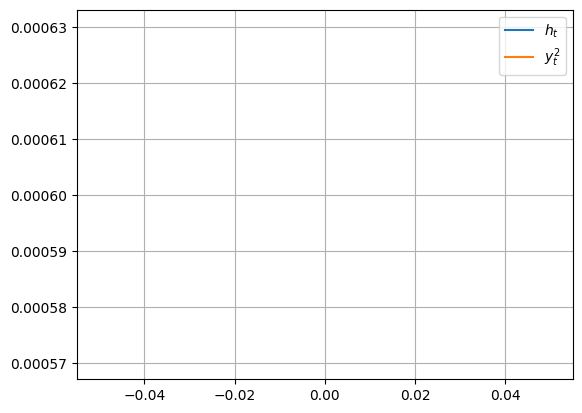

In [60]:
plt.plot(fvm._hist_output, label='$h_t$')
plt.plot(train.values[1:] ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

## `feed_daily_data()`

In [61]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

data_to_cluster_test = test.to_frame().copy()

In [62]:
%%time

fvm.feed_daily_data(test, data_to_cluster=data_to_cluster_test)

KeyboardInterrupt: 

In [63]:
fvm.first_h_current

array([[0.00060013, 0.00060013, 0.00060013, 0.00060013, 0.00060013,
        0.00060013]])

In [64]:
fvm.h

array([0.00060013, 0.00034391, 0.00022055, 0.00016116, 0.00013257,
       0.0001188 , 0.00011218, 0.00010898, 0.00010745, 0.00010671,
       0.00010635, 0.00010618, 0.0001061 , 0.00010606, 0.00010604,
       0.00010603, 0.00010603, 0.00010602, 0.00010602, 0.00010602,
       0.00010602, 0.00010602, 0.00010602, 0.00010602, 0.00010602,
       0.00010602], dtype=float128)

In [65]:
fvm._h_fuzzy_hist

[array([[0.00060013],
        [0.00060013]]),
 array([[0.00060013],
        [0.00067375],
        [0.00071055]]),
 array([[0.00060013],
        [0.00038509],
        [0.0002471 ],
        [0.00015856]], dtype=float128),
 array([[6.00131747e-04],
        [3.60675271e-04],
        [2.16763488e-04],
        [1.30273444e-04],
        [7.82934915e-05]]),
 array([[6.00131747e-04],
        [3.51712378e-04],
        [2.06124068e-04],
        [1.20800785e-04],
        [7.07963403e-05],
        [4.14908049e-05]]),
 array([[6.00131747e-04, 6.00131747e-04],
        [3.61039555e-04, 3.61224451e-04],
        [2.17201575e-04, 2.17424098e-04],
        [1.30668574e-04, 1.30869431e-04],
        [7.86102788e-05, 7.87714340e-05],
        [4.72919825e-05, 4.74132024e-05],
        [2.84508800e-05, 2.85384135e-05]], dtype=float128),
 array([[6.00131747e-04, 6.00131747e-04],
        [3.61053874e-04, 3.67961825e-04],
        [2.17218820e-04, 2.28225390e-04],
        [1.30684159e-04, 1.44122026e-04],
        [7

In [84]:
(fvm._hist_output_fuzzy)

[array([0.00060013]),
 array([0.00071055]),
 array([0.00015856], dtype=float128),
 array([7.82934915e-05]),
 array([4.14908049e-05]),
 array([2.84508800e-05, 2.85384135e-05], dtype=float128),
 array([1.71209057e-05, 3.36629838e-05]),
 array([1.12573136e-05, 1.24241543e-05]),
 array([6.90579755e-06, 7.05580764e-06]),
 array([4.20524538e-06, 4.31713221e-06]),
 array([2.16830005e-05, 3.57313772e-05]),
 array([2.37620052e-06, 5.85123271e-05]),
 array([1.56881430e-05, 8.52670981e-05, 3.05599309e-05]),
 array([1.38482251e-05, 7.51777184e-05, 2.65279067e-05]),
 array([3.13032664e-05, 7.53010607e-05, 4.95579479e-05, 1.10492058e-07],
       dtype=float128),
 array([1.16031473e-04, 4.55474751e-05, 3.85791123e-05, 2.28224493e-05]),
 array([1.37311705e-04, 5.30677525e-05, 2.14974942e-08, 1.17993383e-04],
       dtype=float128),
 array([1.53071949e-04, 5.23491152e-05, 7.12150481e-09, 1.16586358e-04]),
 array([1.44589977e-04, 4.76041907e-05, 5.74366700e-09, 1.07148658e-04]),
 array([1.39726531e-04, 

In [83]:
fvm._h_hist

[array([0.00060013, 0.00060013]),
 array([0.00060013, 0.00067375, 0.00071055], dtype=float128),
 array([0.00060013, 0.00038509, 0.0002471 , 0.00015856], dtype=float128),
 array([6.00131747e-04, 3.60675271e-04, 2.16763488e-04, 1.30273444e-04,
        7.82934915e-05], dtype=float128),
 array([6.00131747e-04, 3.51712378e-04, 2.06124068e-04, 1.20800785e-04,
        7.07963403e-05, 4.14908049e-05], dtype=float128),
 array([6.00131747e-04, 3.61132005e-04, 2.17312839e-04, 1.30769005e-04,
        7.86908582e-05, 4.73525938e-05, 2.84946477e-05], dtype=float128),
 array([6.00131747e-04, 3.64507942e-04, 2.22722252e-04, 1.37403272e-04,
        8.60629098e-05, 5.51690468e-05, 3.65787842e-05, 2.53921651e-05],
       dtype=float128),
 array([6.00131747e-04, 3.65832440e-04, 2.23075785e-04, 1.36095108e-04,
        8.30982330e-05, 5.08074330e-05, 3.11327202e-05, 1.91449319e-05,
        1.18407634e-05], dtype=float128),
 array([6.00131747e-04, 3.65775269e-04, 2.22939644e-04, 1.35884086e-04,
        8.282

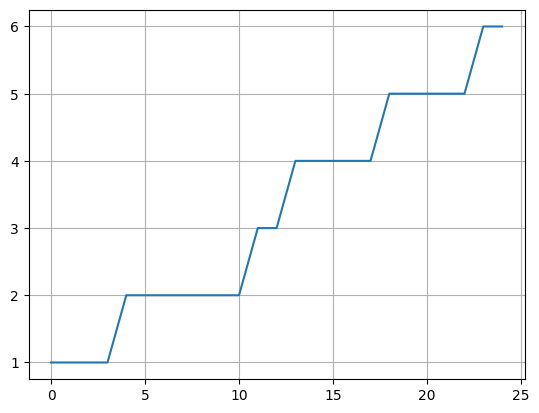

In [68]:
plt.plot(fvm._n_clusters_hist)
plt.grid()

In [69]:
ant_hist = fvm.show_antecedent_hist()

In [70]:
ant_hist

,n_clusters,variance,sigma,potentials_focal,delta_min,x_dim,centers,beta,focals
0,1,2,0.000600,[0.9999978718283026],0.25,1,[[0.024497586556524727]],[0.024497586556524727],[[0.024497586556524727]]
1,1,2,0.001274,[0.999773069330191],0.25,1,[[0.024497586556524727]],[0.050454000116696],[[0.024497586556524727]]
2,1,2,0.001296,[0.9998459715310997],0.25,1,[[0.024497586556524727]],[0.05515397507988553],[[0.024497586556524727]]
3,1,2,0.001353,[0.9998820635331843],0.25,1,[[0.024497586556524727]],[0.06271615791802472],[[0.024497586556524727]]
4,2,2,0.001373,"[0.9998961089821595, 0.9999016070230451]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.06717271394459755],"[[0.024497586556524727], [0.011363621370187172]]"
5,2,2,0.001502,"[0.9999130243148501, 0.999917606166409]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.07853633531478472],"[[0.024497586556524727], [0.011363621370187172]]"
6,2,2,0.001599,"[0.9999179211003683, 0.9999218484375992]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.08835385127504529],"[[0.024497586556524727], [0.011363621370187172]]"
7,2,2,0.001605,"[0.999924929166214, 0.9999283656327734]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.09091189366987354],"[[0.024497586556524727], [0.011363621370187172]]"
8,2,2,0.001612,"[0.9999300294204974, 0.999933084087434]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.0883697106971283],"[[0.024497586556524727], [0.011363621370187172]]"
9,2,2,0.001620,"[0.999929624201468, 0.9999323733986428]",0.25,1,"[[0.024497586556524727], [0.011363621370187172]]",[0.09122822423795242],"[[0.024497586556524727], [0.011363621370187172]]"


In [71]:
fvm.membership_degrees_hist

""


In [72]:
pd.DataFrame.from_records(fvm._parameters_hist, index=fvm.train_data.index[-len(fvm._parameters_hist):])

,alpha_0,alpha,beta
<DATE>,,,
2018-01-04,[0.0003000657791312983],[[0.01]],[[0.49]]
2018-01-05,[0.0003738220359050441],[[0.009995549565020554]],[[0.48978198094127684]]
2018-01-09,[6.997162131588919074e-20],[[3.9011516758662876103e-08]],[[0.6416728773584393064]]
2018-01-10,[8.251970342772458e-36],[[1.0135016584949205e-14]],[[0.6009934859184446]]
2018-01-11,[5.329691386628252e-35],[[1.902288264016916e-16]],[[0.586058611203685]]
2018-01-12,"[3.689640385018791963e-43, 3.2683836293358987934e-41]","[[8.295563352815152028e-12, 8.295634587267004655e-12]]","[[0.6016004934108513918, 0.60190858474135191787]]"
2018-01-15,"[4.2678895256844547e-11, 6.7596916418582285e-06]","[[9.609641356421161e-11, 9.609664758626673e-11]]","[[0.6016242816689159, 0.6018713979849315]]"
2018-01-16,"[5.145448687115379e-12, 3.504678706672949e-07]","[[1.3967635665660978e-12, 1.414999409262714e-12]]","[[0.6083429201304181, 0.6102467241409548]]"
2018-01-17,"[3.618603037995366e-12, 1.2710439987131472e-08]","[[2.3591893916366755e-11, 2.3633889736429858e-11]]","[[0.6089082407850025, 0.6100537300549402]]"


In [73]:
_arr = np.array([[0.0004779073117170634], [0.0004779073117170634]])
np.concatenate((_arr, [_arr.mean(axis=0)]))

array([[0.00047791],
       [0.00047791],
       [0.00047791]])

In [85]:
ls_res = fvm.show_ls_results()
ls_res

,cost,optimality,nfev,njev,status,message,success
0,0.000000e+00,0.000000e+00,1,1,1,`gtol` termination condition is satisfied.,True
1,1.803773e-16,7.100204e-12,18,9,1,`gtol` termination condition is satisfied.,True
2,6.697355e-08,4.612108e-11,15,12,1,`gtol` termination condition is satisfied.,True
3,7.062310e-08,4.708548e-11,5,5,1,`gtol` termination condition is satisfied.,True
4,7.210432e-08,8.641638e-11,5,5,1,`gtol` termination condition is satisfied.,True
5,7.569806e-08,1.685985e-11,7,7,1,`gtol` termination condition is satisfied.,True
6,7.786978e-08,4.449111e-08,4,4,4,Both `ftol` and `xtol` termination conditions are satisfied.,True
7,7.798816e-08,7.000612e-11,8,7,1,`gtol` termination condition is satisfied.,True
8,7.800064e-08,4.401090e-11,6,3,1,`gtol` termination condition is satisfied.,True
9,7.800135e-08,6.770454e-11,1,1,1,`gtol` termination condition is satisfied.,True


In [75]:
fvm.h

array([0.00060013, 0.00034391, 0.00022055, 0.00016116, 0.00013257,
       0.0001188 , 0.00011218, 0.00010898, 0.00010745, 0.00010671,
       0.00010635, 0.00010618, 0.0001061 , 0.00010606, 0.00010604,
       0.00010603, 0.00010603, 0.00010602, 0.00010602, 0.00010602,
       0.00010602, 0.00010602, 0.00010602, 0.00010602, 0.00010602,
       0.00010602], dtype=float128)

In [76]:
fvm.train_data.tolist()

[0.024497586556524727,
 0.02595641356017127,
 0.004699974963189532,
 0.007562182838139188,
 0.004456556026572827,
 0.011363621370187172,
 0.009817515960260561,
 0.0025580423948282486,
 -0.002542182972745232,
 0.002858513540824109,
 0.011462479765255875,
 -0.0065563720076083545,
 0.011274447054389618,
 -0.001230012455199932,
 0.0066535704512181906,
 0.014511322308137795,
 -0.018869573811179385,
 -0.008687663675911127,
 -0.0004940188533373923,
 0.005803011631274049,
 0.008340306008835919,
 -0.015854665547673043,
 -0.007088453629744421,
 -0.024900543873689656,
 0.007950850297817643,
 -0.025959178553413127]

In [77]:
fvm.hist_output

Series([], dtype: float64)

In [78]:
fvm._parameters_hist

[{'alpha_0': array([0.00030007]),
  'alpha': array([[0.01]]),
  'beta': array([[0.49]])},
 {'alpha_0': array([0.00037382]),
  'alpha': array([[0.00999555]]),
  'beta': array([[0.48978198]])},
 {'alpha_0': array([6.99716213e-20], dtype=float128),
  'alpha': array([[3.90115168e-08]], dtype=float128),
  'beta': array([[0.64167288]], dtype=float128)},
 {'alpha_0': array([8.25197034e-36]),
  'alpha': array([[1.01350166e-14]]),
  'beta': array([[0.60099349]])},
 {'alpha_0': array([5.32969139e-35]),
  'alpha': array([[1.90228826e-16]]),
  'beta': array([[0.58605861]])},
 {'alpha_0': array([3.68964039e-43, 3.26838363e-41], dtype=float128),
  'alpha': array([[8.29556335e-12, 8.29563459e-12]], dtype=float128),
  'beta': array([[0.60160049, 0.60190858]], dtype=float128)},
 {'alpha_0': array([4.26788953e-11, 6.75969164e-06]),
  'alpha': array([[9.60964136e-11, 9.60966476e-11]]),
  'beta': array([[0.60162428, 0.6018714 ]])},
 {'alpha_0': array([5.14544869e-12, 3.50467871e-07]),
  'alpha': array([[1

## Plots

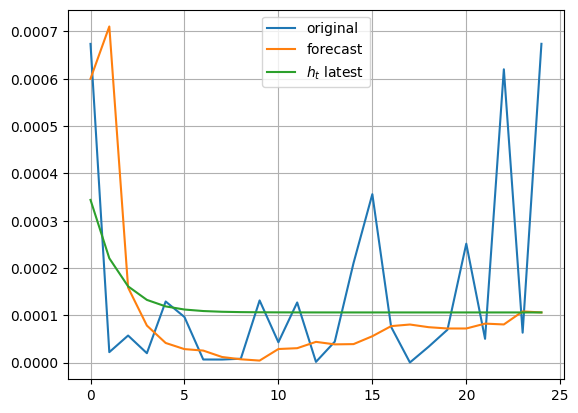

In [87]:
plt.plot(fvm.train_data[1:].values ** 2, label='original')
plt.plot(fvm._hist_output, label='forecast')
plt.plot(fvm.h[1:], label='$h_t$ latest')

plt.legend()
plt.grid()
plt.show()

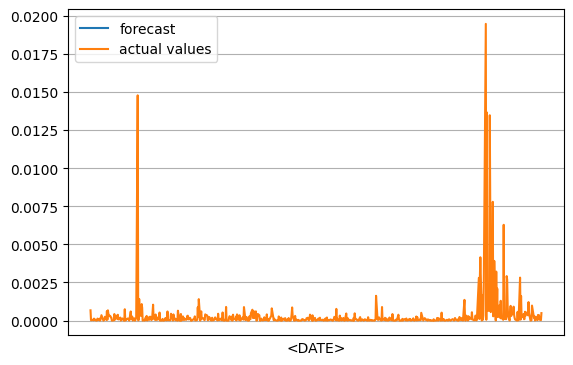

In [80]:
fvm.hist_output.plot(label='forecast')
(test ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

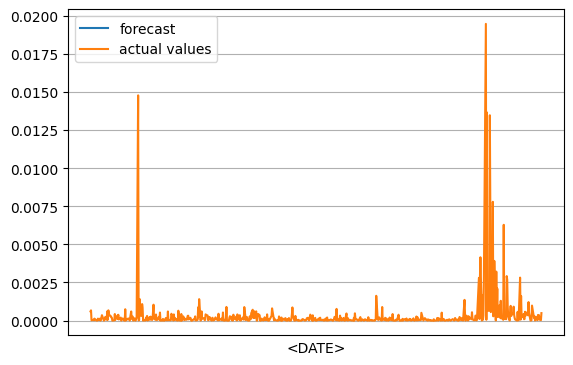

In [81]:
fvm.hist_output.plot(label='forecast')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [82]:
_h_w_nans = np.concatenate([[np.nan for _ in range(input_cut.shape[0] - n_points_fitting)], fvm.h])

plt.plot(_h_w_nans, label='$h_t$')
plt.plot(input_cut.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
input_cut[-n_points_fitting:] ** 2

In [ ]:
fvm._h_hist

In [ ]:
fvm._hist_output

In [ ]:
_p = fvm._parameters_hist[-1]
_p

In [ ]:
calc_cond_var_fuzzy(_p['alpha_0'], _p['alpha'], _p['beta'],
                    input_cut[-n_points_fitting:] ** 2, [input_cut[-n_points_fitting:][0]],
                    fvm._membership_degrees_hist[-1])

In [ ]:
fvm._membership_degrees_hist[-1]

## Errors

In [ ]:
mean_squared_error(y_pred=fvm._hist_output, y_true=fvm.train_data[1:] ** 2, squared=True)

In [ ]:
rmse_ets = mean_squared_error(y_pred=fvm._hist_output, y_true=fvm.train_data[1:] ** 2, squared=False)
rmse_ets

In [ ]:
mean_absolute_percentage_error(fvm._hist_output, fvm.train_data[1:] ** 2)

## RSS plots

In [ ]:
ranges = {}

_step = .05
ranges['alpha_0'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['alpha'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['beta'] = np.arange(0, 1 + _step, _step)

In [ ]:
%%time

rss = {'alpha_0': [], 'alpha': [], 'beta': []}

for _param_1cl in ranges['alpha_0']:
    _alpha_0 = np.concatenate([fvm.alpha_0[:-1], [_param_1cl]])
    _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
    rss['alpha_0'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['alpha']:
    _alpha = np.concatenate([fvm.alpha[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
    rss['alpha'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['beta']:
    _beta = np.concatenate([fvm.beta[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
    rss['beta'].append((fvm._calc_residuals(_params) ** 2).sum())

In [ ]:
%%time

rss = {'alpha_0': {i: [] for i in range(n_clusters)},
       'alpha': {i: [] for i in range(n_clusters)},
       'beta': {i: [] for i in range(n_clusters)}}

for i in range(n_clusters):
    for _param_1cl in ranges['alpha_0']:
        _alpha_0 = np.concatenate([fvm.alpha_0[:i], [_param_1cl], fvm.alpha_0[i + 1:]])
        
        _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
        rss['alpha_0'][i].append((fvm._calc_residuals(_params) ** 2).sum())

_par_name = 'alpha'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _alpha = fvm.alpha.copy()
        _alpha[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())
       
_par_name = 'beta'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _beta = fvm.alpha.copy()
        _beta[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())

In [ ]:
for _param, _rss_cl in rss.items():
    for _cl, _rss in _rss_cl.items():
        plt.plot(ranges[_param], _rss)

        plt.grid()
        plt.title(_param + '\n' + f'cluster #{_cl}')
        plt.show()

# Model w/o seasoning

In [ ]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [ ]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [ ]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [ ]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [ ]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [ ]:
%%time

fvm_vanilla.cluster()

In [ ]:
%%time

fvm_vanilla.fit()

In [ ]:
n_last_points_to_use_for_clustering

In [ ]:
fvm_vanilla.alpha_0

In [ ]:
fvm_vanilla.alpha

In [ ]:
fvm_vanilla.beta

In [ ]:
garch_fitted.params

In [ ]:
fvm_vanilla._parameters_hist

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusters_parameters_current

In [ ]:
data_to_cluster

In [ ]:
fvm_vanilla._membership_degrees_hist

In [ ]:
fvm_vanilla.train_data

## `forecast`

In [ ]:
fvm_vanilla.forecast()

In [ ]:
fvm_vanilla.current_output

In [ ]:
fvm_vanilla._hist_output

In [ ]:
plt.plot(fvm_vanilla.h, label='sqrt(h_t)')
plt.plot(train.values ** 2, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvm_vanilla.h

## `feed_daily_data`

In [ ]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [ ]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

In [ ]:
fvm_vanilla.data_to_cluster

In [ ]:
len(fvm_vanilla._hist_output)

In [ ]:
fvm_vanilla.h

In [ ]:
_.shape

In [ ]:
fvm_vanilla.data_to_cluster[-10:]

In [ ]:
fvm_vanilla.membership_degrees_hist

In [ ]:
fvm_vanilla.hist_output

In [ ]:
test

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusterization_parameters

In [ ]:
fvm_vanilla._parameters_hist

### Plots

In [ ]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

In [ ]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

In [ ]:
(_ - 1) * 100

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

## Diff w/ seasonal model

In [ ]:
np.array(fvm._hist_output) - np.array(fvm_vanilla._hist_output)

In [ ]:
_.mean()

## Same data fed to GARCH(1, 1)

### No retraining

In [ ]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [ ]:
model.volatility

In [ ]:
fitted = model.fit()

In [ ]:
fitted.summary

In [ ]:
fitted.params

In [ ]:
fvm.alpha_0

In [ ]:
fvm.alpha

In [ ]:
fvm.beta

In [ ]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [ ]:
forecast_variance = forecast.variance.iloc[0]

In [ ]:
forecast_variance

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

### With retraining

In [ ]:
%%time

forecast_garch_wr = \
    calculate_retraining_garch_forecasts(train, fvm.train_data[1:],
                                         mean=garch_mean,
                                         vol='GARCH',
                                         p=p,
                                         q=q,
                                         dist=garch_dist)

In [ ]:
rmse_vanilla_wr = mean_squared_error(y_true=fvm.train_data[1:] ** 2, y_pred=forecast_garch_wr, squared=False)
rmse_vanilla_wr

In [ ]:
mean_squared_error(y_true=fvm.train_data[1:101] ** 2, y_pred=forecast_garch_wr[:100], squared=False)

In [ ]:
mean_squared_error(y_pred=fvm._hist_output[:100], y_true=fvm.train_data[1:101] ** 2, squared=False)

In [ ]:
rmse_vanilla_wr == rmse_ets

In [ ]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Plots

In [ ]:
plt.plot(fvm.train_data[1:].values ** 2, label='original')
plt.plot(fvm._hist_output, label='forecast fuzzy GARCH')
plt.plot(forecast_garch_wr, label='forecast vanilla GARCH')

plt.legend()
plt.grid()
plt.show()